# 背景

对指定个股和指数进行30分钟级别的监控，包括趋势、反转指标等，并通过语音进行报告。

本监控在数据上不依赖于zillionare-omega

In [1]:
! export HTTPS_PROXY=""
from alpha.notebook import *
await init_notebook(use_omicron=False)

g = {
    "notified": set()
}

In [2]:
def get_pmae_threshold(code, frame_type, win):
    if code in ["000001.XSHG"]:
        return {
            "30m": {
                5: 1.51e-4,
                10: 1.51e-4
            }
        }.get(frame_type, {}).get(win, 3e-4)
    
def maline_turn(bars, win, err_threshold):
    close = bars["close"].copy()
    close /= close[0]
    
    ma = moving_average(close, win)[-7:]
    coef, pmae = polyfit(ma)
    if pmae > err_threshold:
        return None
        
    a, b, c = coef
    
    vx = 7 - round(-b/(2 * a))
    if 0 < vx <=7:
        return ma[-vx] < ma[-1], bars["frame"][-vx]
    else:
        return None
    
def notify(title, details):
    ft = details.get("frame_type")
    frame = details.get("frame")
    code = details.get("code")
    win = details.get('win')
    
    key = f"{code}{frame}{ft}{win}"
    
    if key not in g["notified"]:
        say(title)
        g["notified"].add(key)

In [3]:
def mon():
    code, name, frame_type = '000001.XSHG', '沪指', '30m'
    bars = jq_get_bars(code, 15, frame_type)
    
    for win in [5, 10]:
        win = 5
        res = maline_turn(bars, win, get_pmae_threshold(code, frame_type, win))
        if res is not None:
            flag, frame = res

            desc = "向上拐头" if flag else "向下拐头"
            tm = arrow.get(frame, 'Asia/Shanghai').humanize(locale='zh')
            title = f"{name}30分钟线在{tm}发生{desc}"
            details = {
                "frame": frame,
                "flag": flag,
                "win": win,
                "frame_type": frame_type,
                "code": code
            }

            notify(title, details)
            cs = Candlestick(frames={"30m": [5, 10, 20, 30, 60]}, plot_window_size=80)
            
            bars = jq_get_bars(code, 119, frame_type)
            cs.plot_bars(bars, title=f"{name} {frame_type}")

In [4]:
bars = jq_get_bars("000001.XSHG", 99, '30m')

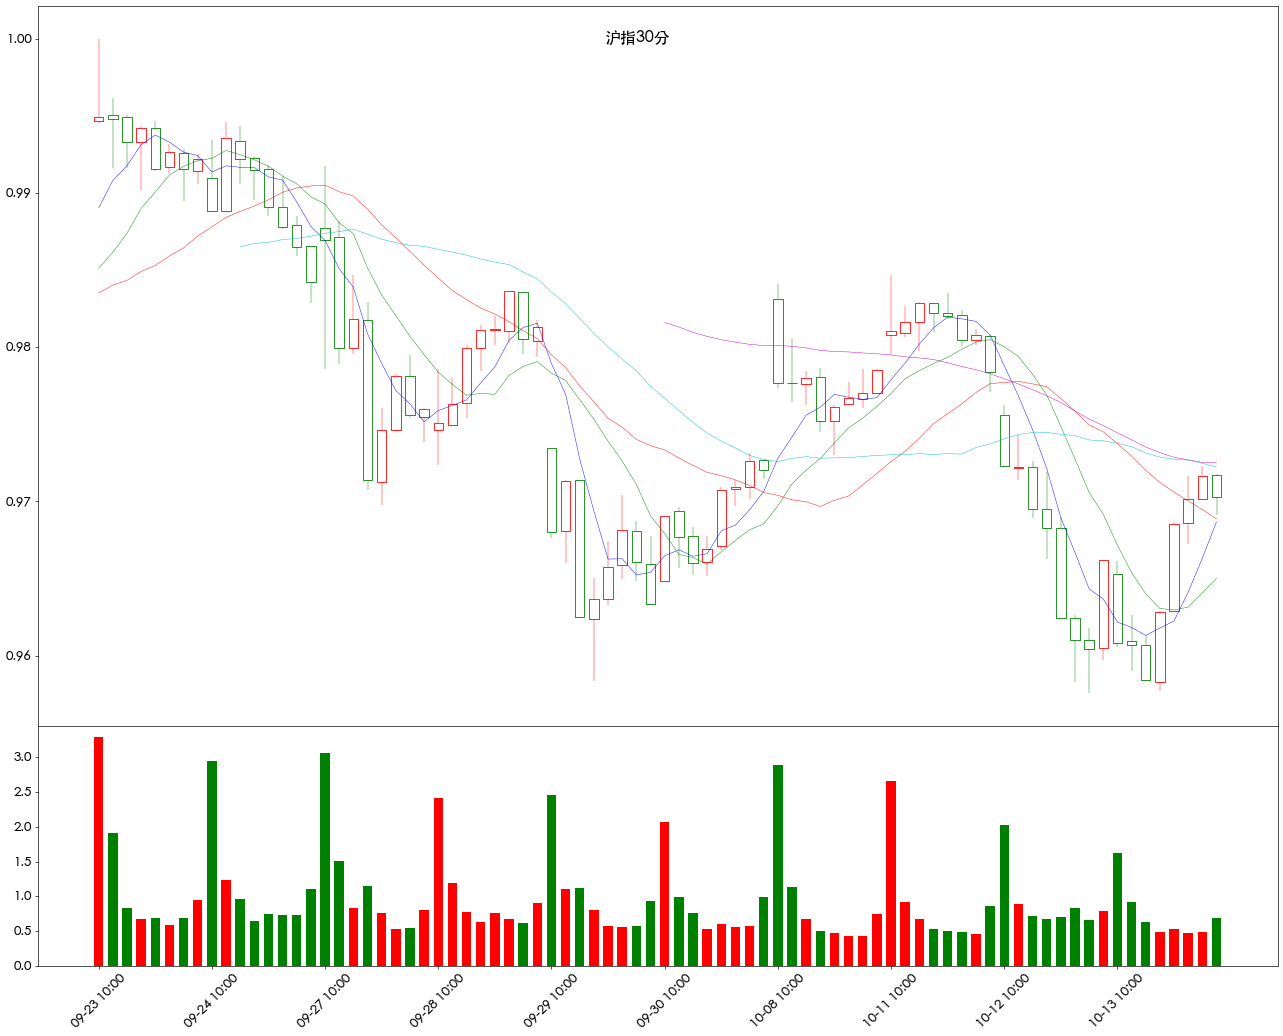

In [13]:
cs = Candlestick(frames={"30m": [5, 10, 20, 30, 60]}, n_plot_bars=80)
cs.plot_bars(bars, title="沪指30分")